# <p style="text-align: center;"> TextXD 2018 Hack session<br><br>Word embedding models for charter schools:<br>Detecting discursive themes through querying neural nets
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>December 2018

---------------------

# Introduction
What are the major themes deployed in the website self-descriptions of charter schools--an educational innovation (7,000 schools strong!) intended to meet the particular educational desires of diverse communities?

This notebook gives starter code to answer this question by loading a 300-dimension word embedding model (WEM),  iteratively querying it to detect coherent clusters of terms, and visualizing these clusters in two dimensions. The data come from my web-scraping of all 6,862 charter schools open in the 2015-16 school year. The embeddings were created in the word2vec implementation in gensim. 

This notebook was prepared for a hack session at [TextXD 2018](http://www.textxd.org/) at the [Berkeley Institute for Data Science (BIDS)](https://bids.berkeley.edu/), UC Berkeley. This code is available in [my GitHub repository](https://github.com/jhaber-zz/charters4textxd2018).

##  Guiding questions
- What educational ideologies--i.e., relatively coherent clusters of terms related to learning tasks, modes, methods, etc.--do charter schools use in their websites?
- Which ideologies are more similar? Which are more different?

## About my research 
My research categorizes charter schools' educational ideologies by creating dictionaries of coherent clusters of terms (through WEMs) and quantifying schools' emphasis on these ideologies (through count-based dictionary methods). I then use mixed regression models to connect identities with community characteristics (i.e., school district-level race and class) to document how charter schools' identities reflect segregated social environments.

My project is currently cross-sectional, but plans are in the works to get longitudinal data on charter schools using the Internet Archive. I will use these data to examine survival and geographic dispersion of the different identity categories over time.

You can find more code related to my research on [my main GitHub repo](https://github.com/jhaber-zz/Charter-school-identities) and [my project organization](https://github.com/URAP-charter)--the latter especially has lots of tools for web-scraping, data management, text analysis, and more.

## About sharing data
I'm happy to share and explore these data with you! And as a graduate student who spent years painstakingly collecting them, I'm not yet ready to share these data with the world. So please respect my choice to share with you, the hack session participants, by NOT downloading these data. If you're interested in continuing your analysis or in collaborating with me, please reach out to me at jhaber@berkeley.edu. 

# Initialize Python

In [ ]:
# Import key packages:
import gensim # for word embedding models
from sklearn.manifold import TSNE # For visualizing word embeddings

import matplotlib # for visualizations
import matplotlib.pyplot as plt # for easy access
import seaborn as sns # To make matplotlib prettier

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('fivethirtyeight')
sns.set(style='white')
sns.despine()

In [ ]:
# Define data and model file paths
charters_data_path = "../data/charter_data_201516.csv" # statistical data on ~5K charter schools (no text)
charters_text_path = "../data/charter_text_201516.csv" # statistical and text data on ~1K charter schools
model_path = "../data/word2vec.charters.txt"

# Load & inspect model

In [ ]:
# Load word2vec model:
model = gensim.models.KeyedVectors.load_word2vec_format(model_path)

In [ ]:
# Show list of words in model
print(len(model.vocab), "unique words/common phrases in model vocabulary")
sorted(list(model.vocab)[:200])

## Query model

Word embedding models excel at detecting relationships between words. For instance, some of the most useful things you can do are to detect words similar to a given word, or to look for words similar to a given word group but dissimilar to some other word group.

Note that this model is created using words as well as common phrases in the corpus, such that a commonly co-occurring word pair such as "critical thinking" is expressed as the unigram "critical_thinking". Other common word pairs are joined together without a space (probably due to some flaw in the extraction/download process), such that "inquiry based" becomes "inquirybased".

Note also that the distances between word vectors are established via cosine similarity. Cosine similarity measures the angle between vectors such that a score of 0 indicates perfect opposition (orthogonality or 90 degrees between vectors) and 1 indicates perfect similarity (parallelity or 0 degrees between vectors). In a picture:
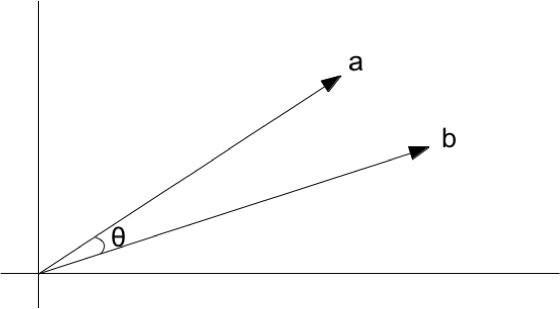

In [ ]:
# Find 10 most similar words to a single word...
model.most_similar("critical_thinking")

In [ ]:
# ...or 15 most similar to a group of words
model.most_similar(["critical_thinking", "inquiry-based", "problem-solve", "experiential"], topn=15)

In [ ]:
# Find cosine distance between two given word vectors
model.similarity('problem-solve','disciplinary')

In [ ]:
# Examine contrasting word vectors
model.most_similar(positive = ["problem-solve"], negative = ["disciplinary"], topn = 15)

# Detect discursive themes 

Here are some tools for examining whether a dictionary (group of thematically related terms) has _coherence_ (close relations between component words of a given dictionary in terms of semantics and meaning) and _distinctiveness_ (distant relations between component words of a given dictionary and words of some other, supposedly distinct dictionary). Below are also some ways to visualize these contrasts use TSNE, a probability-based method of projecting vector relationships from a high-dimensional space (here, 300) to a more easily visualized low-dimensional space (here, 2).

## Define helper functions

In [ ]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of terms within one dictionary with all other terms in that same dictionary,
    effectively measuring the coherence of the dictionary.
    ...question for development: does it make sense to compare the average cosine similarity score between all terms 
    in thisdict and the average cosine similarity among the total model vocabulary? (Could that be, by definition, 0?)
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_sim = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dict_avg_sim = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_sim

In [ ]:
def dict_distinct(dict1, dict2, wem_model):
    '''Computes the average cosine distance score of terms in dict1 with all terms in dict2,
    effectively measuring the opposition/non-coherence between the two dictionaries.
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine distance score of each word in dict1 with all words in dict2.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dicts_avg_dist = 0
    
    # Compute average cosine similarity score of each term in dict1 with all terms in dict2:
    for word in dict1:
        word_avg_dist = (wem_model.distances(word, other_words=dict2).sum())/len(dict2) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dicts_avg_dist = word_avg_dists/len(dict1) # Find average cosine distance score by dividing sum by # words
    
    return dicts_avg_dist

## Examine coherence and distinctiveness

In [ ]:
# Define dictionary of thematic terms:
inquiry = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

# Check semantic coherence of this dictionary: 0 means not coherent, 1 means very coherent
dict_cohere(inquiry, model)

In [ ]:
# Another example
discipline = ['discipline', 'disciplinary', 
          'no-excuses', 'zero-tolerance', 'zero_tolerance', 'zero-tolerance_policy', 
          'expel', 'expellable', 'expulsion', 'suspension', 'suspended', 
          'misbehavior', 'disobedience', 'absenteeism', 'inappropriate', 
          'perpetrator', 'crime', 'criminal', 'illegal', 'drugs', 'drug-related', 
          'violation', 'violate', 'penalty', 'punish', 'penalize', 
          'authority', 'deterrence', 'deter', 
          'behavioral_expectations']

# Assess coherence
dict_cohere(discipline, model)

In [ ]:
# How different are these dictionaries? 
# NOTE: The result given is cosine DISTANCE, so higher numbers mean MORE distinctiveness (and less similarity).
dict_distinct(inquiry, discipline, model)

Take-aways from the above:
The inquiry dictionary has more coherence (0.62) than does the discipline dictionary (0.41)--that is, its terms are more closely related in terms of their meanings. Also, the two dictionaries are highly distinct, with a cosine distance of 0.74. In other words, based on these measures, they are capturing very different themes.

## Visualize themes

In [ ]:
def display_closestwords(wem_model, word, plotnumber):
    '''Use tSNE to display a spatial map (i.e., scatterplot) of words vectors close to given word in Word2Vec model.
    Projects each word to a 2D space (a reduction from model size) and plots the position of each word with a label.
    Based on this blog: 
    https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)
    
    Args:
        Word2Vec model
        Input word
        Number of words to plot
    Returns:
        Visualization of relationships between given word and its closest word vectors
    '''
    
    dimensions = 300
    
    arr = np.empty((0,dimensions), dtype='f')
    word_labels = [word]

    # get close words
    close_words = wem_model.similar_by_word(word, plotnumber)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [ ]:
# Display 50 closest words to 'discipline'
display_closestwords(model, "expel", 50)

In [ ]:
# Display 50 closest words to 'inquiry-based'
display_closestwords(model, "inquiry-based", 50)

## Visualize a binary contrast

In [ ]:
# construct a combined dictionary with 100 words for each concept
numterms = 100
inquiry_big = inquiry + [word for (word, closeness) in model.most_similar(inquiry, topn=(numterms-len(inquiry)))]
discipline_big = discipline + [word for (word, closeness) in model.most_similar(discipline, topn=(numterms-len(discipline)))]

core_words = inquiry + discipline
all_words = inquiry_big + discipline_big

print("Some words from the combined dictionary: ")
print(sorted(all_words[:30]))

In [ ]:
# preparing for visualization: find similarities between two focal terms and all words we'll map
x = [model.similarity('inquiry-based', word) for word in all_words]
y = [model.similarity('expel', word) for word in all_words]

In [ ]:
# here's a visual of the inquiry/discipline binary: 
# top-left half is formal discipline, bottom-right half is inquiry-based learning
# words from core dictionary are highlighted
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(all_words)):
    if all_words[i] in core_words:
        ax.annotate(all_words[i], (x[i], y[i]), fontweight='bold', color="blue").set_fontsize(16)
    else:
        ax.annotate(all_words[i], (x[i], y[i])).set_fontsize(16)
ax.set_xlim(0, 1)
ax.set_xlabel('Cosine similarity with word "inquiry-based"')
ax.set_ylim(0, 1)
ax.set_ylabel('Cosine similarity with word "expel"')
#ax.set_title()
ax.yaxis.label.set_fontsize(24)
ax.xaxis.label.set_fontsize(24)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of formal discipline (top-left) and inquiry-based learning (bottom-right) word vectors

In [ ]:
# Save visual for later
fig.savefig("../data/WEM-visual_TextXD18.png")